
#Water quality of groundwater drillings in Israel (2012 - 2020)


Underground water production drilling site



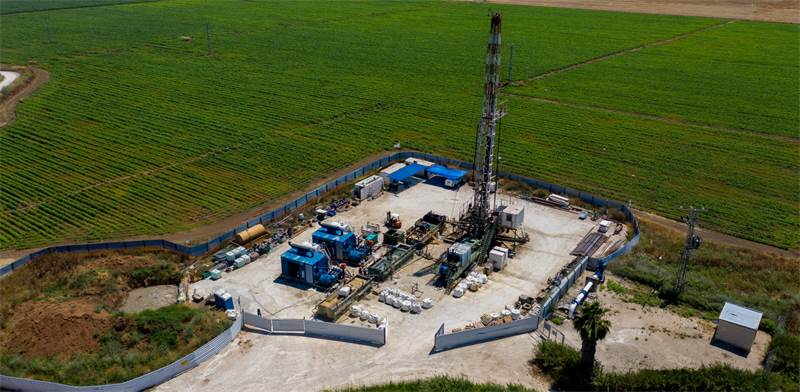



Groundwater production drillings - Drills used for agricultural irrigation and drinking water



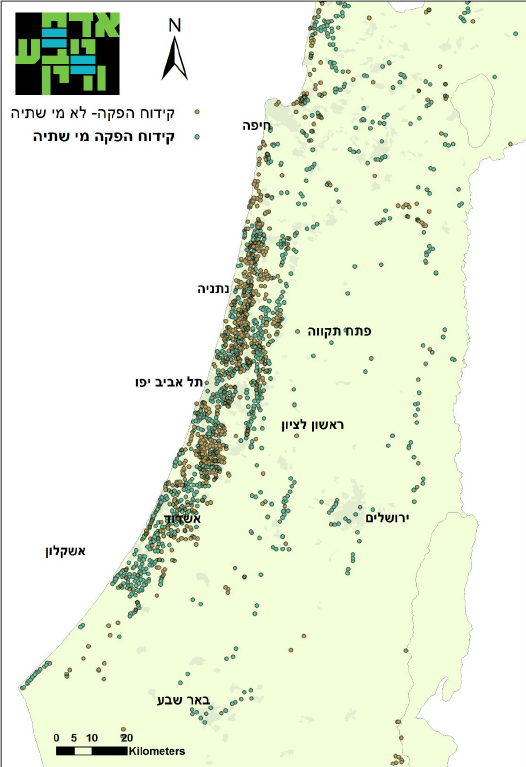

In [1]:
from IPython.display import Image, display;
print('\nUnderground water production drilling site\n')
display(Image(filename='Water_drilling.png',width=800, height=400, embed=True))
print('\n\nGroundwater production drillings - Drills used for agricultural irrigation and drinking water\n')
display(Image(filename='water_drilling_map.png',width=500, height=600, embed=True))

In [2]:
!pip install plotly --upgrade
!pip install cufflinks

     |████████████████████████████████| 23.9 MB 14 kB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [3]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Timestamp
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

import plotly.express as px
import cufflinks as cf
cf.go_offline()
import plotly.io as pio
pio.renderers.default = 'colab'

## Data Importing
Import three 'csv' files, Set column names to english (original is hebrew) and drop unneccesery columns and rows


In [4]:
# Import main data file 'borehole_wq_params.csv'
header_list = ['bore_id', 'bore_name', 'cell_no', 'owner_type', 'parameter', 'isr_standart', 'stnd_value', 'sample_date', 'sample_value', 'diff_precent']
df = pd.read_csv('/content/borehole_wq_params.csv', names= header_list, skiprows=1, header=0)
print("Imported borehole_wq_params.csv, with {:,d} lines".format(len(df)))

df = df.drop('isr_standart', axis=1) # insignificant column data

# Import second file 'boreholeswater.gov.il.csv' with supplementary data
cols = ['bore_id', 'bore_name', 'owner_id', 'owner_name', 'owner_type', 
        'status', 'water_grp', 'aquifer', 'flow_rate', 'product_id', 
        'national_id','product_zone', 'agro_zone', 'geo_zone', 'admin_zone', 
        'plan_zone']
bores = pd.read_csv('/content/boreholeswater.gov.il.csv', header=0, names=cols)
bores = bores[['bore_id', 'aquifer']]
time.sleep(1)
print("Imported boreholeswater.csv, with {:,d} lines".format(len(bores)))
# Merage two imported files
df1 = df.merge(bores, how='left', on='bore_id') 

# Import third file 'lots.csv' with supplementary data
lots_cols = ['basin_id', 'basin_name', 'sub_basin_id', 'sub_basin_name','cell_no', 'lot_name']
lots = pd.read_csv('/content/lots.csv', header=0, names=lots_cols, encoding='iso8859_8')
time.sleep(1)
print("Imported lots.csv, with {:,d} lines".format(len(lots)))

lots = lots[['cell_no', 'basin_name']]

# Merage third imported file with main df
df1 = df1.merge(lots, how='left', on='cell_no')
time.sleep(1)
print("\nMerging imported tables, got {:,d} lines".format(len(df1)))

# Drop spesific columns: with missing data which can not be obtained and unimportnat ones
df1 = df1.dropna(subset=['cell_no', 'basin_name'])

# Drop spesific rows from df which are unimportnant
x_df1 = ~df1.owner_type.isin(['פן ביני', 'יוזום', 'מחקר'])
df1 = df1[x_df1]
time.sleep(1)
print("Droping nan's and unimportnant data, left with \033[1m{:,d}\033[0m lines\n".format(len(df1)))

df1.head(3)

Imported borehole_wq_params.csv, with 44,216 lines
Imported boreholeswater.csv, with 3,814 lines
Imported lots.csv, with 173 lines

Merging imported tables, got 44,216 lines
Droping nan's and unimportnant data, left with 42,400 lines



bore_id          bore_name  cell_no  ... diff_precent        aquifer  basin_name
0   229312  פ בית העמק עמקה 3    360.0  ...         10.9  קנומן - טורון  גליל מערבי
1   229312  פ בית העמק עמקה 3    360.0  ...         44.9  קנומן - טורון  גליל מערבי
2   229319      פ כברי החוגים    350.0  ...         13.5  קנומן - טורון  גליל מערבי

[3 rows x 11 columns]

## Data Transformation
Filling missing values and adding new columns

In [5]:
# Fill missing 'aquifer' values by grouping 'cell_no', retreving the most common aquifer value exisiting and setting it for that 'cell_no'
f = lambda x: next(iter(x.mode()), np.nan)
df1[['aquifer']] = df1[['aquifer']].fillna(df1.groupby('cell_no').transform(f))

df1 = df1.dropna(subset=['aquifer']) # drop  remainding rows with null values in 'aquifer'
df1 = df1.dropna(subset=['owner_type']) # drop remainding rows with null values in 'owner_type'

# Fill missing owner_type by iterating over the rows and searching for key values based on first charecters of bore_name column
owner_dict = {'פ':'פרטי','מק': 'חברת מקורות', 'מח': 'מחקר', 'נפ': 'ניטור פסולת', 'יו': 'יוזום', 'נד': 'ניטור דלק','נת':'ניטור תעשיה','הש': 'השפלה','המ': 'המרכז'}
for ind in df1.index:
  if(pd.isnull(df1['owner_type'][ind])):
    char = df1['bore_name'][ind].split()[0]
    if char in owner_dict:
      df1['owner_type'][ind] = owner_dict[char]
    else:
      df1['owner_type'][ind]
print('\nFilling 403 missing values in owner_type by infering it from the first later in bore_name column, for example: ניטור תעשיה :נת')      

# Add a new column 'owner_type_eng' (english translation of 'owner_type')
owner_dict_eng = {'פרטי':'private', 'חברת מקורות': 'mekorot', 'ניטור פסולת': 'waste monitor',
                  'ניטור דלק': 'fuel monitor','ניטור תעשיה':'industrial monitor','השפלה': 'lowland','המרכז': 'centeral'}
df1['owner_type_eng'] = df1['owner_type'].map(owner_dict_eng)

# Add new column 'basin_name_eng' (english translation of 'basin_name')
basin_dict_eng = {'גליל מערבי': 'west galilee', 'ההר המזרחי': 'est mountains', 'כנרת': 'kinneret', 'שולי ההר': 'mountains slope', 'חוף': 'cost',
                  'ירקתן': 'yarkon', 'כרמל': 'carmel', 'נגב והערבה': 'negev & harava'}
df1['basin_name_eng'] = df1['basin_name'].map(basin_dict_eng)

# pd.set_option('display.max_rows', None)

# Add new column 'year' by extracting the year from 'sample_date' column
df1['year'] = pd.DatetimeIndex(df1['sample_date']).year

# Add new column 'month_yr' by extracting month-year from 'sample_date' column
df1['month_yr'] = df1['sample_date'].astype('datetime64[M]')

# Add new column 'natural_log' to calculate the natural logarithm of 'diff_precent_2' column
df1['diff_percent_2'] = [0.1 if x == 0 else x for x in df1.diff_precent]
df1['natural_log'] = np.log(df1['diff_percent_2'])

# Group parameters by pollutant family into lists and then make a dictionary 
lst_fuel = ['BENZ', 'ETBN', 'ETDB', 'MTBE', 'NAPT', 'TBA', 'TOLU', 'XYLE','14DIX']
lst_industry = ['AS', 'CCL4', 'CD', 'CDCE', 'CHLF', 'CR', 'DCET', 'DCEY', 'HG', 'NI', 'PB', 'TCEY', 'TDCE', 'TECE', 'VYCL']
lst_pesticide = ['ATRA', 'LIND', 'SIMZ']
lst_organic = ['NO3']
lst_chloride = ['Cl']
dict_contaminators = {'fuel': lst_fuel, 'industrial': lst_industry, 'pesticide': lst_pesticide, 'organic': lst_organic, 'chloride': lst_chloride}

# Add a new column 'category' based on dict_contaminators
def map_value(x):
  for k,v in dict_contaminators.items():
    if x in v:
      return k
x = df1.loc[:,'parameter']      
df1['parm_cat'] = list(map(map_value, x))
time.sleep(1)
print('Add a new column \033[1mparm_cat\033[0m for grouping pollutants into 5 main families\n')

# Add a new column 'Aquifer_2' 
def map_value_2(x):
  for k,v in dict_aquifer_eng.items():
    if x in v:
      return k
dict_aquifer_eng = {'pleistocene': 'פליו-פליסטוקן מילוי', 'cenomanian': ['קנומן - טורון','קנומן תחתון','קנומן בלתי מחולק'], 'neogene': ['ניאוגן - מילוי','ניאוגן - בזלת']
               , 'eocene': 'איאוקן', 'cretaceous': 'קרטיקון תחתון', 'holecene': 'הולוקן', 'jurassic': 'יורא', 'senonian': 'סנון'}
df1['aquifer_2'] = ""
x = df1.loc[:,'aquifer']      
df1['aquifer_2'] = list(map(map_value_2, x))
time.sleep(1)
print("Final dataframe no. of records - \033[1m{:,d}\033[0m lines\n".format(len(df1)))
time.sleep(1)
df1.head(3)


Filling 403 missing values in owner_type by infering it from the first later in bore_name column, for example: ניטור תעשיה :נת
Add a new column parm_cat for grouping pollutants into 5 main families

Final dataframe no. of records - 41,740 lines



bore_id          bore_name  cell_no  ... natural_log  parm_cat   aquifer_2
0   229312  פ בית העמק עמקה 3    360.0  ...    2.388763  chloride  cenomanian
1   229312  פ בית העמק עמקה 3    360.0  ...    3.804438   organic  cenomanian
2   229319      פ כברי החוגים    350.0  ...    2.602690  chloride  cenomanian

[3 rows x 19 columns]

##Exploratory data using plots

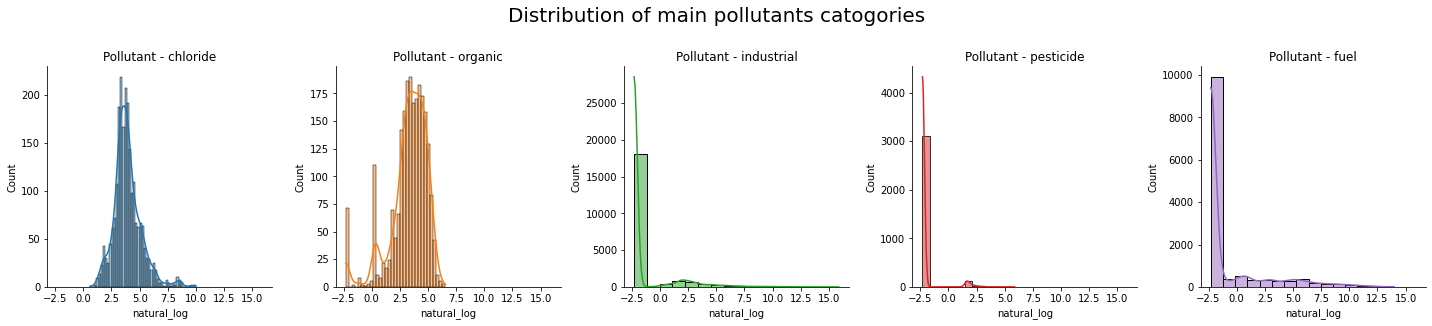

In [ ]:
# Histogram of main pollutant categories
g = sns.FacetGrid(df1, hue='parm_cat',sharey=False, col='parm_cat', height=4, aspect=1)
g.map(sns.histplot, 'natural_log', kde=True)
sns.set_context("notebook", rc={"font.size":8, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'style': 'darkgrid'}) 
g.set_titles('Pollutant - {col_name}')
plt.suptitle('Distribution of main pollutants catogories', fontsize= 20, y=1.12)
plt.show()

* We can see that natural chemicals such has chloride and organic compounds (such as nitrogen) have normal distribution in nature. Whereas other pollutants families which are influenced by men actions, are not normally distributed.

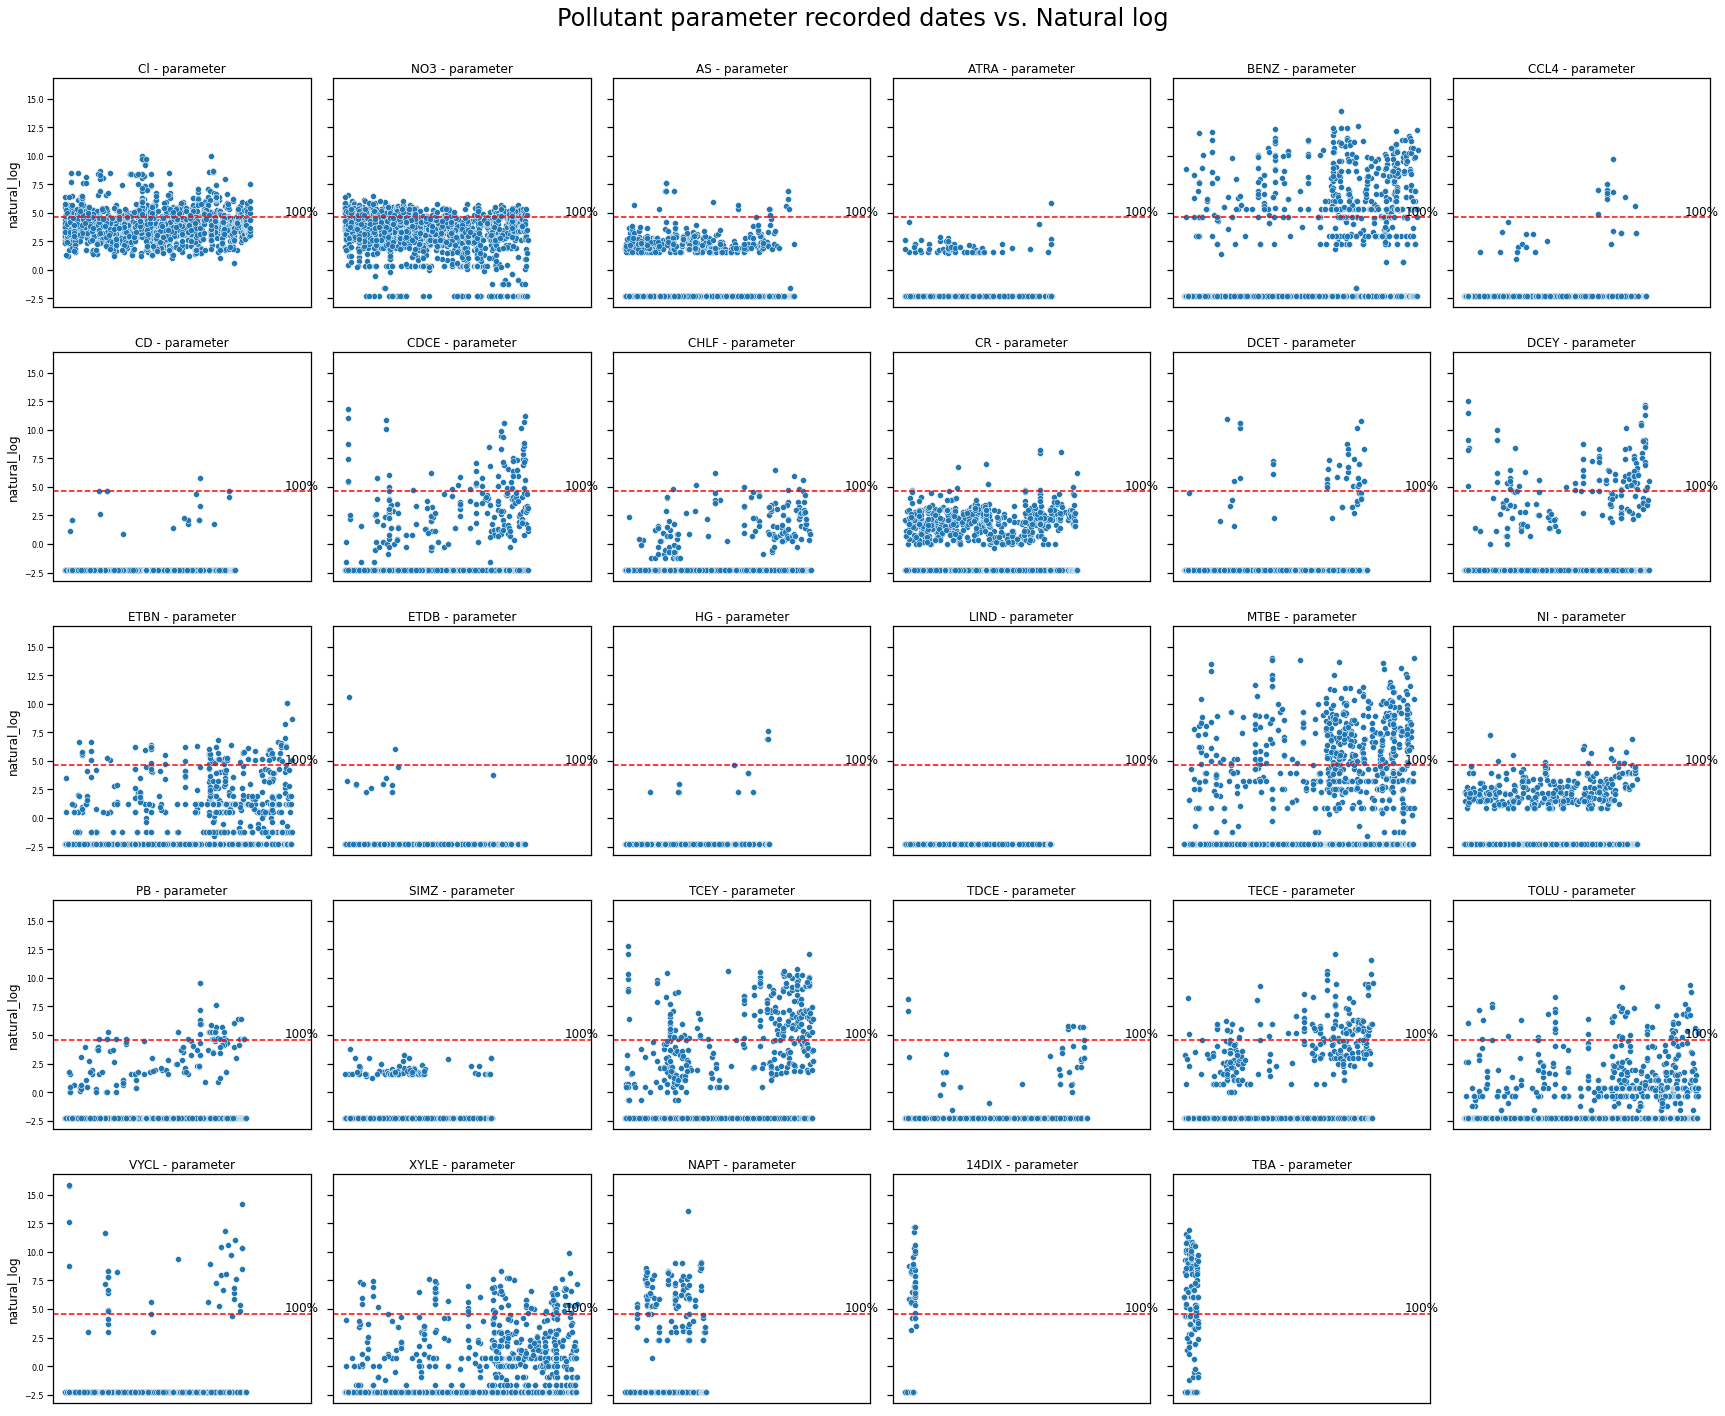

In [ ]:
# Scatter plots of each pollutant parameter: Dates vs. natural_log (100% red line represents limit of standart value )
g = sns.FacetGrid(df1, sharey=True, col='parameter', col_wrap=6, height=4, aspect=1, despine=False, margin_titles=True)
g.set(xticks=[])
g.map(plt.axhline, y=4.6, color= 'red',linestyle = '--')
g.map(plt.annotate, s='100%', xy=(0.9, 0.4), xycoords='axes fraction', color='black', fontsize=12)
g.map(sns.scatterplot,'sample_date', 'natural_log')
g.set_titles('{col_name} - parameter')
g.fig.subplots_adjust(top=0.93, hspace= 0.2)
g.fig.suptitle('Pollutant parameter recorded dates vs. Natural log', fontsize=24)
plt.show()

From these scatter plots we notice the following:
* Most measurements are zeros (74%) and the rest of the measurements are widely distributed.
* Most of the measurements are below the standard limit, but when there are exceedances (6.7%) then they are very high.

### Analysis of Max values per month

In [ ]:
# Matrix correlation between pollutants parameters using Heatmap
dfx = df1.groupby(['parameter', 'month_yr', 'parm_cat'])['natural_log'].max().to_frame().reset_index()
x = dfx.pivot_table(values='natural_log',index='month_yr',columns='parameter').reset_index(level='month_yr').sort_values('month_yr')
x = x.iloc[:,1:]
x.corr().iplot(kind='heatmap', colorscale='spectral', title='Matrix correlation of pollutants parameters (Max value per month)')

* We see strong correlation between the follwoing parameters:\
(ATAR,SIMZ), (BENZ,ETBN), (BENZ,MTBE), (BENZ,TOLU), (BENZ,XYLE), (CDCE,CHLF),(CDCE,DCEY), (CDCE,TCEY), (CDCE,TECE), (CHLF,DCEY), (DCEY,TCEY), (ETBN,MTBE),(ETBN,TOLU), (ETBN,XYLE), (MTBE,TOLU), (MTBE,XYLE), (TCEY,TECE), (TOLU,XYLE)

In [ ]:
# Compare parameters max values per month between main pollutant groups
dfx = df1.groupby(['parameter', 'month_yr', 'parm_cat'])['natural_log'].max().to_frame().reset_index()
for i in ['fuel','industrial','pesticide']:
  dfx[dfx.parm_cat==i].iplot(kind='line', mode='lines', x='month_yr', y='natural_log', categories='parameter', 
                            theme='solar', colorscale='spectral', xTitle='month-year', yTitle='Natural log',
                            title=(f'{i.title()} pollutants'), hline= dict(y=4.6, color='red', dash='dot', width=3),
                            annotations= dict(text='100% standard',x='2020-10-01',y=5, showarrow=False, size=14, textangle=360))
dfx[dfx.parm_cat.isin(['chloride','organic'])].iplot(kind='line',mode='lines',x='month_yr', y='natural_log', categories='parameter',
                      theme='solar', colors=['pink','blue'], xTitle='month-year', yTitle='Natural log', 
                      title='Chloride & organic pollutants', hline= dict(y=4.6, color='red', dash='dot', width=3),
                      annotations= dict(text='100% standard',x='2020-10-01',y=5, showarrow=False, size=14, textangle=360))

From these graphs we can see the following:
* We spot a relation between few parameters belonging to the same pollutant group, which facilited in similar behaviour pattern.
* Even after isolating only the Max measurements from the rest of the data, it did not help us very much in detecting fixed behaviour pattern. The measurements are all over with extremes highs and lows.


---
After all the analysis we have done until now, we found the following:
74% of measurements are zeros, 19% are above 0 and bellow 100 (standard limit) and only 7% are above the standard.\
This information may lead us to try another analysis approach which is called EVA (Extreme value analysis - Values occurring at the
tails of a probability distribution). In this analysis we try to assess and predict the future by looking only at the extreme values. We divide our data into 'blocks' and decide on a threshold for the extrema values.


### Analysis of main pollutants groups versus main country area



Factories reporting pollutants against a map divided by aquifer layers



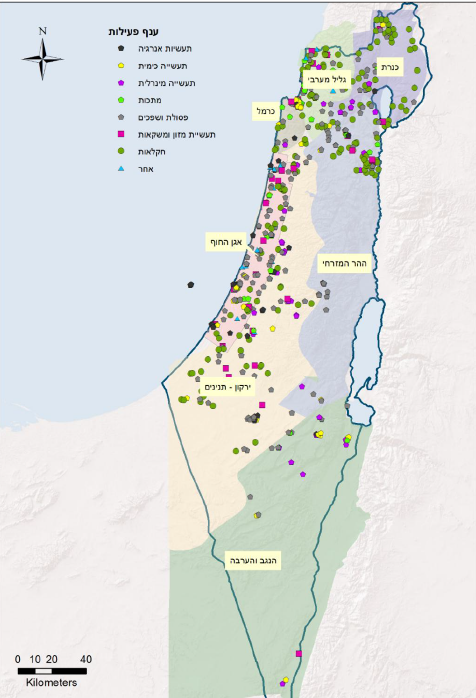

In [ ]:
print('\n\nFactories reporting pollutants against a map divided by aquifer layers\n')
display(Image(filename='pollutants_map.png', width=450, height=700, embed=True))

* Out of all the industrial areas in the country, only 20 sites are continuaslly being monitored for pollutants in underground water, thru special monitor drillings.

In [ ]:
# Categorical plots of 'basin_area' against measured 'natural_log' values by pollutant categories for production drillings
parm_cat_ordered = CategoricalDtype(['fuel','industrial','pesticide','chloride','organic'], ordered=True) # reorder parm_cat
x = df1.loc[df1.owner_type.isin(['פרטי', 'חברת מקורות']), :]
x['parm_cat'] = x['parm_cat'].astype(parm_cat_ordered)
x.sort_values('parm_cat', inplace=True)

for i in x.parm_cat.unique():
  y = x[x.parm_cat == i]
  fig = px.strip(y, x="basin_name_eng",
                    y="natural_log", 
                    color="parameter", 
                    stripmode='group',
                    height=450, 
                    hover_name='parm_cat',
                    category_orders={'basin_name_eng': ['west galilee','kinneret','carmel','cost','yarkon','mountains slope','est mountains','negev & harava']},
                    template="seaborn",
                    labels={'basin_name_eng': 'Country area', 'natural_log': 'Log value'},
                    title= (f'{i.title()} pollutant'))
  fig.add_hline(y=4.6,line_width=2, line_dash="dot", line_color="red",
                annotation_text="100% standard", 
                annotation_position="top right",
                annotation_font_size=14,
                annotation_font_color="red")
  fig.update_layout(title_pad=dict(b=0.1))
  fig.show()

* The cost area is the one area which is significantly affected by fuel pollutants in underground water.
* Industrial pollutants are present in all the areas of the country, but with big concentration in the ‘cost’ and ‘yarkon’ areas.
* Chloride and organic pollutants are present in all areas of country.
* Most of the measurements do not exceed above the standard limit.


In [ ]:
# Categorical plots of 'basin_area' against measured 'natural_log' values by pollutant categories for monitor drillings
parm_cat_ordered = CategoricalDtype(['fuel','industrial','pesticide','chloride','organic'], ordered=True) # reorder parm_cat
x = df1.loc[df1.owner_type.isin(['ניטור דלק', 'ניטור פסולת', 'ניטור תעשיה', 'השפלה']), :]
x['parm_cat'] = x['parm_cat'].astype(parm_cat_ordered)
x.sort_values('parm_cat', inplace=True)

for i in x.parm_cat.unique():
  y = x[x.parm_cat == i]
  fig = px.strip(y, x="basin_name_eng",
                    y="natural_log", 
                    color="parameter", 
                    stripmode='group',
                    height=450, 
                    hover_name='parm_cat',
                    category_orders={'basin_name_eng': ['west galilee','kinneret','carmel','cost','yarkon','mountains slope','est mountains','negev & harava']},
                    template="seaborn",
                    labels={'basin_name_eng': 'Country area', 'natural_log': 'Log value'},
                    title= (f'{i.title()} pollutant'),
                    range_x=[-0.5,7.5])
  fig.add_hline(y=4.6,line_width=2, line_dash="dot", line_color="red",
                annotation_text="100% standard", 
                annotation_position="top right",
                annotation_font_size=14,
                annotation_font_color="red")
  fig.show()

* Fuel pollutants are present in all areas of the country with many high exceedance values above the standard limit. Also, the cost area stands out with high quantity of abnormal measurements.
* Industrial pollutants are predominantly present in the 'cost' and 'carmel' areas with high quantity of abnormal measurements.
* Industrial pollutants penetrate underground water all over the country, while not all industrial areas in the country are being monitored for water pollutants.

### Analysis based of geological aquifer layers



Geological map of aquifer layers



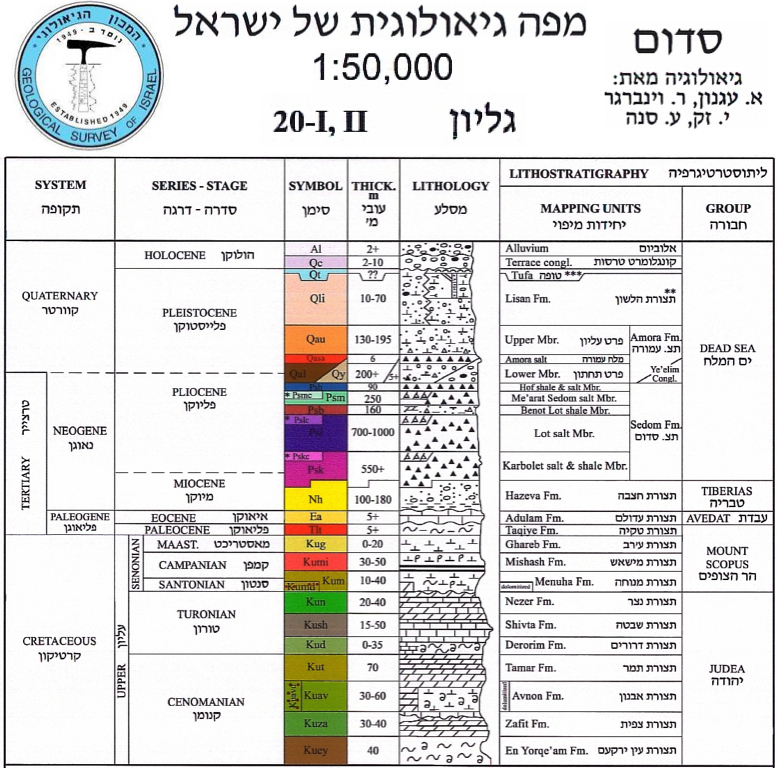

In [ ]:
print('\n\nGeological map of aquifer layers\n')
display(Image(filename='geological_map.png',width=700, height=700, embed=True))

In [ ]:
# Total number of 'cell_no' (water drillings) per 'aquifer_2'
aquifer_ordered = CategoricalDtype(['holecene', 'pleistocene', 'neogene', 'eocene', 'senonian', 'cretaceous', 'cenomanian', 'jurassic'], ordered=True) # reorder aquifer_2 by layer depth
x = df1.groupby('aquifer_2',as_index=False)['bore_id'].nunique()
x['aquifer_2'] = x['aquifer_2'].astype(aquifer_ordered)
x.sort_values('aquifer_2', inplace=True)

fig = px.bar(x,  
             x='aquifer_2', 
             y='bore_id',
             text='bore_id',
             color='aquifer_2',
             template='seaborn',
             color_discrete_sequence=px.colors.qualitative.Set2,
             title= 'Total no. of drillings per Geological layer (Depth level left to right)',
             labels = {'aquifer_2': 'Aquifer layer', 'bore_id': '# Drill sites'},
             height=500,
             width=1000)
fig.update_traces(textposition='outside')
fig.show()

* 78% of underwater drillings are being made into the second and third geo layers (Pleistocene, Neogene).

In [ ]:
col_list = list(['owner_type_eng', 'aquifer_2'])
basin_order = ['west galilee', 'kinneret', 'carmel', 'cost', 'yarkon', 'mountains slope', 'est mountains', 'negev & harava']

for i in range(0,2):
  x = pd.crosstab(df1.basin_name_eng, df1[col_list[i]], normalize='index').loc[basin_order]
  fig = px.bar(x,
              barmode='stack',
              template='seaborn',
              color_discrete_sequence=px.colors.qualitative.Set2,
              title= (f'Country area vs. Owner type (%)' if i==0 else (f'Country area vs. Aquifer geo layer (%)')),
              labels = {'basin_name_eng': 'country area', 'aquifer_2': 'Aquifer layer', 'owner_type_eng': 'Owner type'},
              height=500,
              width=1200)
  fig.show()

## Conclusions:
* We find a relation between the 'cost' area which is only being drilled to the second geo layer (Pleistocene), to high level of fuel pollutants in production water drillings. This is supported by the fact that we do see high levels of fuel pollutants all over the country areas in monitoring drills.
* Most measurements with high level pollutants (Industrial and Fuel) can be found in the second and third geo layers (Pleistocene, Neogene).
* Although we find high levels of contaminations under Fuel and Industrial facilities, their impact on nearby production water drillings high contamination levels, is relatively low.
